In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Activation, Input, Concatenate, Layer
from keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




```
# Ce texte est au format code
```

## Definition des constantes (batch_size, image size, labels)

In [ ]:
labels = ['NORMAL', 'PNEUMONIA']
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_DEPTH = 1
EPOCH = 12

## Fonction pour obtenir les donnees

*   Élément de liste
*   Élément de liste



In [ ]:
def get_images(path_image):
  list_images = []
  for label in labels:
    path_image_label = path_image + '/' + label
    fichiers = [f for f in os.listdir(path_image_label) if os.path.isfile(os.path.join(path_image_label, f))]
    for fichier in fichiers:
      try:
        img = cv.imread(path_image_label + '/' + fichier, cv.IMREAD_GRAYSCALE)
        resized_img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        list_images.append([resized_img, labels.index(label)])
      except:
        print(fichier)

  return np.array(list_images)

## Chargement des donnees de train de validation et de test

In [ ]:
train_data = get_images('/content/drive/My Drive/chest_xray/train')
val_data = get_images('/content/drive/My Drive/chest_xray/val')
test_data = get_images('/content/drive/My Drive/chest_xray/test')

### Donnees entrainement

In [ ]:
print('{} images in training set'.format(len(train_data)))
print('--- {} NORMAL IMAGES IN TRAINING SET'.format([y for _, y in train_data].count(0)))
print('--- {} PNEUMONIA IMAGES IN TRAINING SET'.format([y for _, y in train_data].count(1)))

5071 images in training set
--- 1268 NORMAL IMAGES IN TRAINING SET
--- 3803 PNEUMONIA IMAGES IN TRAINING SET


### *Donnees de Validation

In [ ]:
print('{} images in validation set'.format(len(val_data)))
print('--- {} NORMAL IMAGES IN VALIDATION SET'.format([y for _, y in val_data].count(0)))
print('--- {} PNEUMONIA IMAGES IN VALIDATION SET'.format([y for _, y in val_data].count(1)))

160 images in validation set
--- 80 NORMAL IMAGES IN VALIDATION SET
--- 80 PNEUMONIA IMAGES IN VALIDATION SET


### Donnees de Test

In [ ]:
print('{} images in test set'.format(len(test_data)))
print('--- {} NORMAL IMAGES IN TEST SET'.format([y for _, y in test_data].count(0)))
print('--- {} PNEUMONIA IMAGES IN TEST SET'.format([y for _, y in test_data].count(1)))

624 images in test set
--- 234 NORMAL IMAGES IN TEST SET
--- 390 PNEUMONIA IMAGES IN TEST SET


# Visualisation et pretraitement des donnees

*   Élément de liste
*   Élément de liste



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


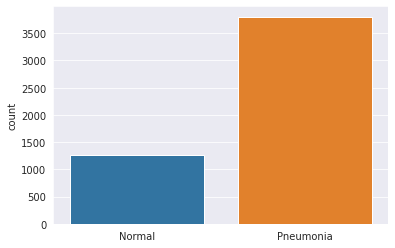

In [ ]:
l = []
for i in train_data:
    if(i[1] == 0):
        l.append("Normal")
    else:
        l.append("Pneumonia")
sns.set_style('darkgrid')
sns.countplot(l)   

Les donnees semblent desequilibrees.Nous utiliserons laugmentation de donnees

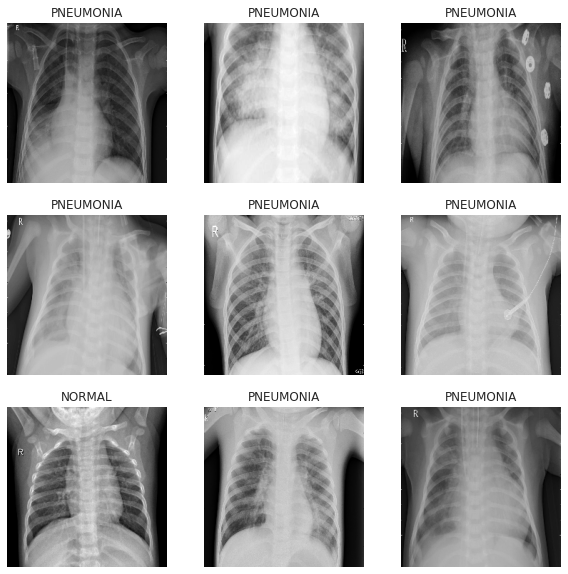

In [ ]:
plt.figure(figsize=(10, 10))
for k, i in np.ndenumerate(np.random.randint(train_data.shape[0], size=9)):
    ax = plt.subplot(3, 3, k[0] + 1)
    plt.imshow(train_data[i][0], cmap='gray')
    plt.title(labels[train_data[i][1]])
    plt.axis("off")

## Traitement des donnees

Nous allons creer et utiliser une fonction appelee prepare_data() qui normalisera les images (en divisant chaque pixel par 255) et remodelera le tableau à la forme appropriee. Apres cela, la fonction renverra separement les tableaux X et y de nos ensembles.

In [ ]:
def prepare_data(data):
    x = []
    y = []
    
    for feature, label in data:
      x.append(feature)
      y.append(label)

    x = (np.array(x) / 255).reshape(-1,IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH)
    y = np.array(y)
        
    return x, y

In [ ]:
x_train, y_train = prepare_data(train_data)
x_val, y_val = prepare_data(val_data)
x_test, y_test = prepare_data(test_data)

In [ ]:
print('The new shape of images is {}'.format(x_train[0].shape))
print('Number of images train is {}'.format(x_train.shape[0]))

The new shape of images is (224, 224, 1)
Number of images train is 5071


## processus Augmentation des donnees

In [ ]:
datagen = ImageDataGenerator(
    rotation_range = 20, 
    zoom_range = 0.2, 
    width_shift_range=0.15,  
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip = False,  
    vertical_flip=False,
    fill_mode="nearest")

# Construire le modele

In [ ]:
class Model2:
  @staticmethod
  def build(width, height, depth, classes, reg):
    inputShape = (height, width, depth)

    # Input
    input_layer = Input(shape=inputShape, name='Image_input')
    conv_layer_1 = Conv2D(32, (5, 5), strides=(2, 2), padding="same",
                   kernel_regularizer=reg, input_shape=inputShape,
                   name='Conv_1')(input_layer)
    batch_norm_1 = BatchNormalization(name='Batch_1')(conv_layer_1)
    dropout_1 = Dropout(0.2, name='Drop_1')(batch_norm_1)

    # Part 1
    conv_layer_2 = Conv2D(64, (3, 3), strides=(2, 2), padding="same",
                   kernel_regularizer=reg, input_shape=inputShape,
                   name='Conv_2_1_1')(dropout_1)
    batch_norm_2 = BatchNormalization(name='Batch_2_1_1')(conv_layer_2)
    dropout_2 = Dropout(0.2, name='Drop_2_1_1')(batch_norm_2)

    conv_layer_3 = Conv2D(128, (3, 3), strides=(2, 2), padding="same",
                   kernel_regularizer=reg, input_shape=inputShape,
                   name='Conv_2_1_2')(dropout_2)
    batch_norm_3 = BatchNormalization(name='Batch_2_1_2')(conv_layer_3)
    dropout_3 = Dropout(0.2, name='Drop_2_1_2')(batch_norm_3)

    conv_layer_4 = Conv2D(256, (5, 5), strides=(2, 2), padding="same",
                   kernel_regularizer=reg, input_shape=inputShape,
                   name='Conv_2_1_3')(dropout_3)
    batch_norm_4 = BatchNormalization(name='Batch_2_1_3')(conv_layer_4)
    max_pool_4 = MaxPool2D((2,2) , strides = 2 , padding = 'same',
                           name='Max_Pool_2_1')(batch_norm_4)
    dropout_4 = Dropout(0.2, name='Drop_2_1_3')(max_pool_4)


    # Part 2
    conv_layer_5 = Conv2D(64, (3, 3), strides=(2, 2), padding="same",
                   kernel_regularizer=reg, input_shape=inputShape,
                   name='Conv_2_2_1')(dropout_1)
    batch_norm_5 = BatchNormalization(name='Batch_2_2_1')(conv_layer_5)
    max_pool_5 = MaxPool2D((2,2) , strides = 2 , padding = 'same',
                           name='Max_Pool_2_2_1')(batch_norm_5)
    dropout_5 = Dropout(0.2, name='Drop_2_2_1')(max_pool_5)

    conv_layer_6 = Conv2D(128, (5, 5), strides=(2, 2), padding="same",
                   kernel_regularizer=reg, input_shape=inputShape,
                   name='Conv_2_2_2')(dropout_5)
    batch_norm_6 = BatchNormalization(name='Batch_2_2_2')(conv_layer_6)
    max_pool_6 = MaxPool2D((2,2) , strides = 2 , padding = 'same',
                           name='Max_Pool_2_2_2')(batch_norm_6)
    dropout_6 = Dropout(0.2, name='Drop_2_2_2')(max_pool_6)

    # Part 3
    conv_layer_7 = Conv2D(64, (7, 7), strides=(2, 2), padding="same",
                   kernel_regularizer=reg, input_shape=inputShape,
                   name='Conv_2_3')(dropout_1)
    batch_norm_7 = BatchNormalization(name='Batch_2_3')(conv_layer_7)
    max_pool_7 = MaxPool2D((4, 4) , strides = 4 , padding = 'same',
                           name='Max_Pool_2_3_1')(batch_norm_7)
    max_pool_8= MaxPool2D((2, 2) , strides = 2 , padding = 'same',
                          name='Max_Pool_2_3_2')(max_pool_7)
    dropout_7 = Dropout(0.2, name='Drop_2_3')(max_pool_8)

    # Concatenate layer
    merged_layer = Concatenate(name='Concat')([dropout_4, dropout_6, dropout_7])
    
    # fully-connected layer
    flatten = Flatten(name='Flatten')(merged_layer)
    dense_1 = Dense(256, activation='relu', name='FC1')(flatten)
    dense_2 = Dense(128, activation='relu', name='FC2')(dense_1)

    final_layer = Dense(classes, activation='sigmoid')(dense_2)
   
    # return the constructed network architecture
    return Model(inputs=input_layer, outputs=final_layer, name="Model_2")

In [ ]:
model = Model2.build(width=IMG_WIDTH, height=IMG_HEIGHT, depth=IMG_DEPTH, classes=1, reg=l2(0.0005))

In [ ]:
model.summary()

Model: "Model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_input (InputLayer)        [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 112, 112, 32) 832         Image_input[0][0]                
__________________________________________________________________________________________________
Batch_1 (BatchNormalization)    (None, 112, 112, 32) 128         Conv_1[0][0]                     
__________________________________________________________________________________________________
Drop_1 (Dropout)                (None, 112, 112, 32) 0           Batch_1[0][0]                    
____________________________________________________________________________________________

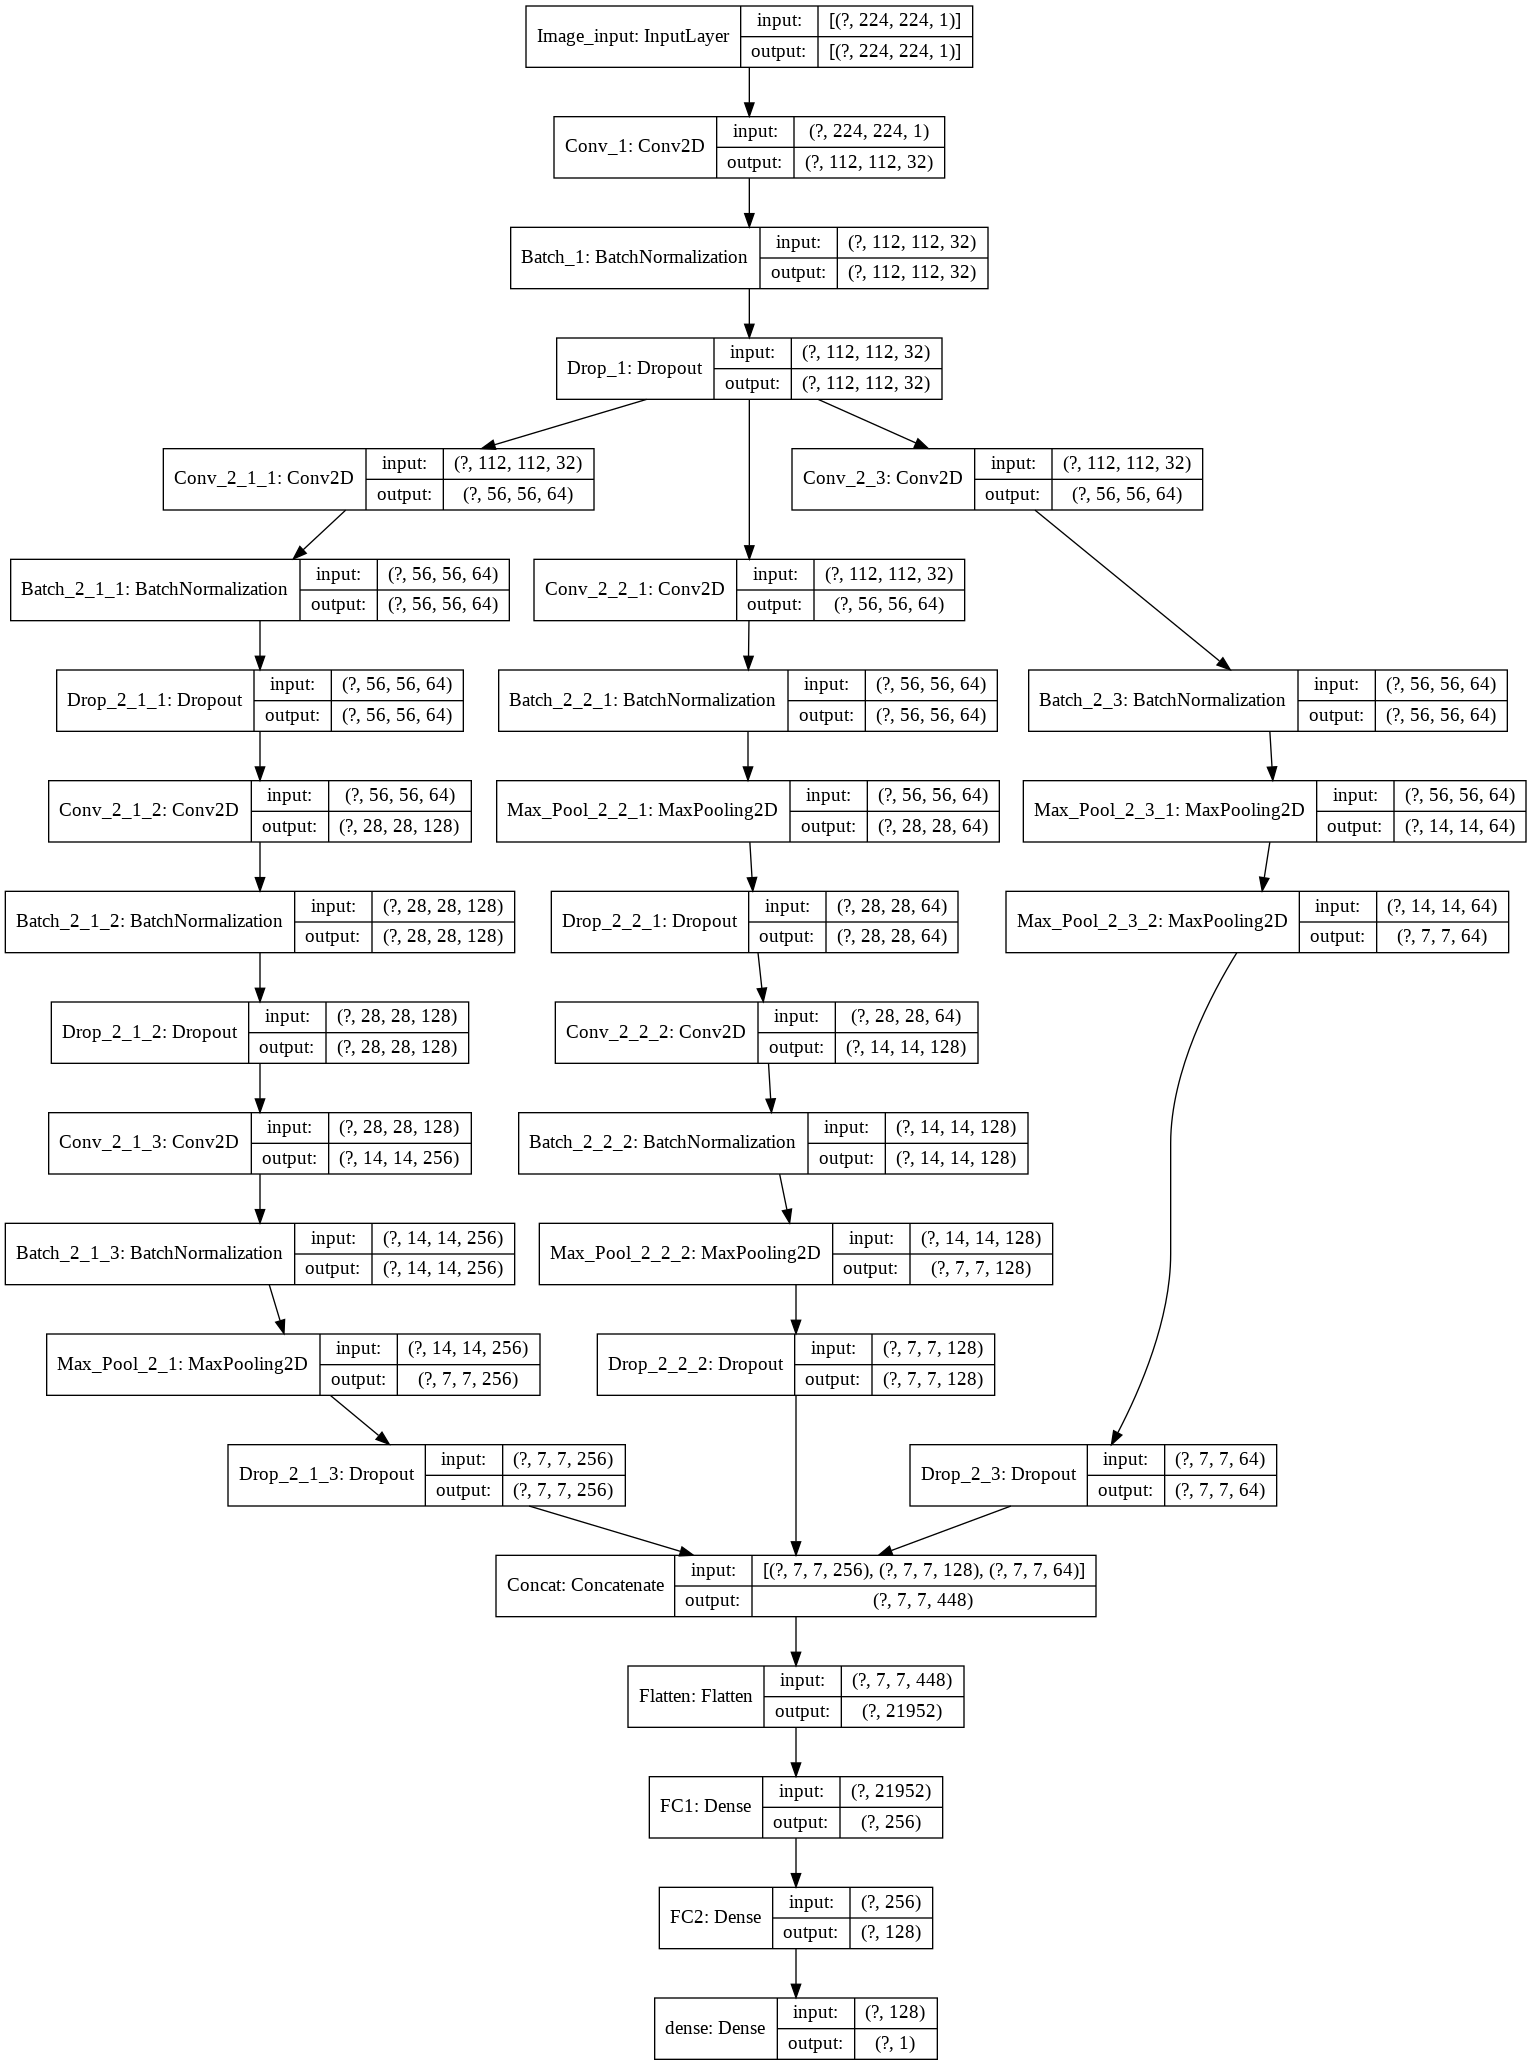

In [ ]:
plot_model(model, 'model2.png', show_shapes=True)

In [ ]:
opt = tf.keras.optimizers.Adam(lr=1e-4, decay=1e-4 / EPOCH)

# Compiler le model

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Entrainer le modele

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size = BATCH_SIZE) ,epochs = EPOCH , validation_data = (x_val, y_val),
                    steps_per_epoch=len(x_train) // BATCH_SIZE)

Epoch 1/12
158/158 [==============================] - 21s 130ms/step - loss: 0.7098 - precision: 0.8424 - recall: 0.9220 - val_loss: 2.2924 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/12
158/158 [==============================] - 20s 127ms/step - loss: 0.4914 - precision: 0.9187 - recall: 0.9399 - val_loss: 3.6908 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/12
158/158 [==============================] - 20s 127ms/step - loss: 0.4596 - precision: 0.9325 - recall: 0.9396 - val_loss: 3.8592 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/12
158/158 [==============================] - 20s 129ms/step - loss: 0.4348 - precision: 0.9427 - recall: 0.9407 - val_loss: 1.5189 - val_precision: 0.5031 - val_recall: 1.0000
Epoch 5/12
158/158 [==============================] - 20s 127ms/step - loss: 0.4142 - precision: 0.9464 - recall: 0.9447 - val_loss: 1.0796 - val_precision: 0.5926 - val_recall: 1.0000
Epoch 6/12
158/158 [==============================] - 20s 129ms/step - loss

In [ ]:
evaluate = model.evaluate(x_test,y_test, verbose=0)
print("Loss of the model is - " , evaluate[0])
print("Precision of the model is - " , evaluate[1]*100 , "%")
print("Recall of the model is - " , evaluate[2]*100 , "%")

Loss of the model is -  0.6567012667655945
Precision of the model is -  84.51327681541443 %
Recall of the model is -  97.94871807098389 %


# Analyse apres entrainement du modele

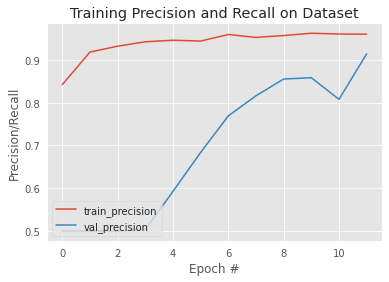

In [ ]:
# plot the training loss and accuracy
N = EPOCH
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history['precision'], label="train_precision")
plt.plot(np.arange(0, N), history.history['val_precision'], label="val_precision")
plt.title("Training Precision and Recall on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Precision/Recall")
plt.legend(loc="lower left")
plt.savefig("plot.png")

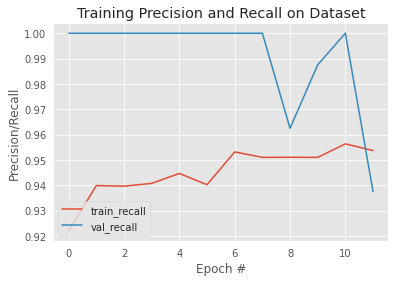

In [ ]:
# plot the training loss and accuracy
N = EPOCH
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history['recall'], label="train_recall")
plt.plot(np.arange(0, N), history.history['val_recall'], label="val_recall")
plt.title("Training Precision and Recall on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Precision/Recall")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [ ]:
predictions = np.array(tf.greater(model.predict(x_test), .5))
predictions = predictions.reshape(1,-1)[0]
predictions = np.array([0 if i == False else True for i in predictions])
predictions[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.95      0.70      0.81       234
Pneumonia (Class 1)       0.85      0.98      0.91       390

           accuracy                           0.88       624
          macro avg       0.90      0.84      0.86       624
       weighted avg       0.89      0.88      0.87       624



In [ ]:
cm = confusion_matrix(y_test, predictions)
cm

array([[164,  70],
       [  8, 382]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

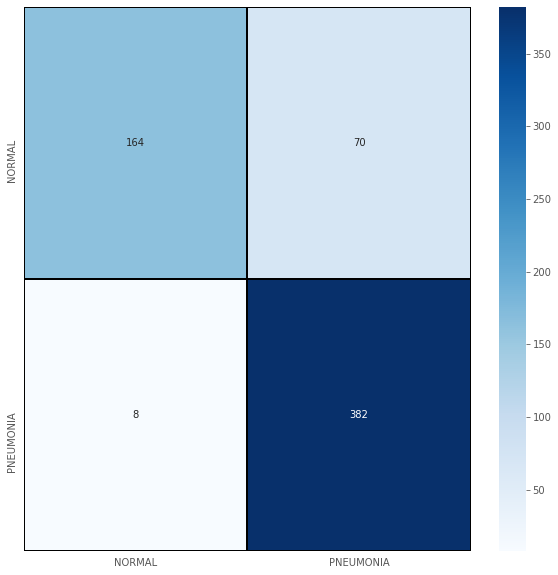

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]  

### Certaines classes sont  correctement predites

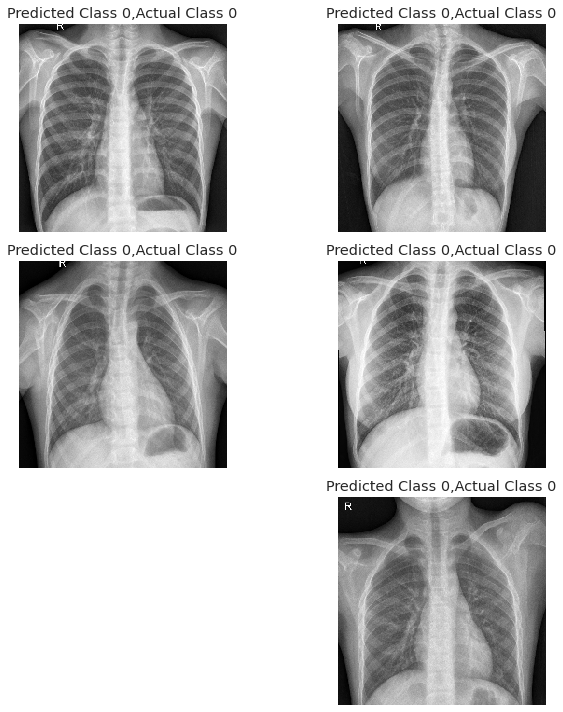

In [ ]:
i = 0
plt.figure(figsize = (10,10))
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(224,224), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

###quelques classes mal predites

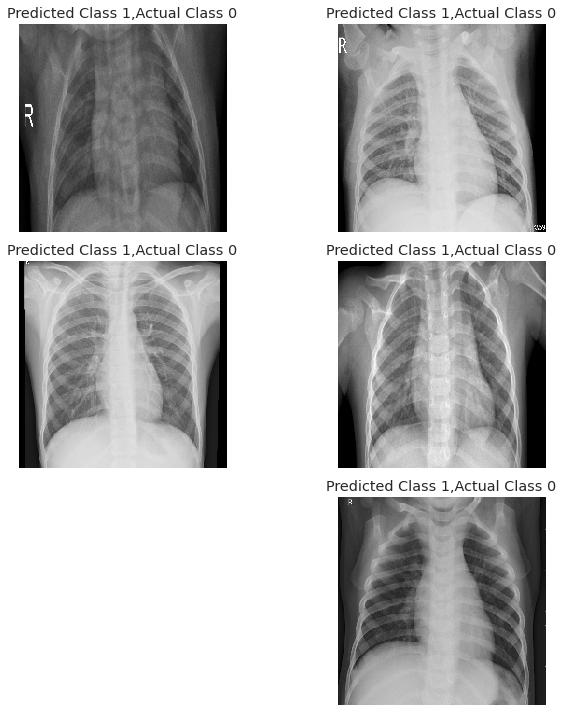

In [ ]:
i = 0
plt.figure(figsize = (10,10))
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(224,224), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [ ]:
model.save('Pneumonie.h5')